In [ ]:
#Copyright 2025 Stevens Ricardo Bohorquez Ruiz

#Licensed under the Apache License, Version 2.0 (the "License");
#you may not use this file except in compliance with the License.
#You may obtain a copy of the License at

#    http://www.apache.org/licenses/LICENSE-2.0

#Unless required by applicable law or agreed to in writing, software
#distributed under the License is distributed on an "AS IS" BASIS,
#WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#See the License for the specific language governing permissions and
#limitations under the License.

# **Aplicación de Métodos de Ensamble y Evaluación de Modelos**

# **Introducción**

La regresión lineal es una herramienta eficaz para abordar cálculos complejos en el ámbito financiero. En este escenario, presentamos un conjunto de datos cuyo objetivo es predecir los costos o cargos del seguro médico de forma individual, considerando variables como la edad, el sexo, las personas dependientes, el índice de masa corporal (IMC), la región geográfica y si la persona es fumadora o no.

Por tal motivo, el presente análisis comparativo evalúa el rendimiento de tres métodos de ensamblamiento: **Bagging, Boosting y Stacking** aplicados al Medical Cost Personal Dataset, un conjunto de datos utilizado para predecir los gastos médicos individuales a partir de variables demográficas y de estilo de vida. El objetivo principal fue identificar cuál de estos enfoques ofrece la mejor precisión y capacidad de generalización al momento de estimar los costos médicos.

Cada modelo fue entrenado utilizando un pipeline de procesamiento estructurado, seguido por una evaluación rigurosa a través de métricas clave como MAE, RMSE, MAPE y R², tanto en las fases de entrenamiento y prueba como en validación cruzada. A continuación, se presenta la comparación de resultados y la interpretación correspondiente, destacando el modelo que mostró mejor desempeño en el contexto del problema.a

Para la industria, especialmente en el sector de los seguros médicos, es crucial identificar con rapidez y precisión los factores de riesgo que determinan estos costos. Por lo tanto, el objetivo es explorar y aplicar diferentes metodos de ensamble, como el Bagging, Stacking y Boosting para identificar la eficacia de estos metodos en el entrenamiento de modelos de inteligencia artificial.



# **Descripción del problema:**

### MLP aplicado a la previsión de gastos de seguros

### **Tipo de problema**: Regresión

### **Conjunto de datos**: https://www.kaggle.com/datasets/mirichoi0218/insurance

# **Medical Cost Personal Datasets**

#### **Insurance forecasting using linear regression**

"Machine Learning with R" by Brett Lantz is a book that provides an introduction to machine learning with R. As far as I know, Packt Publishing does not publish its datasets online unless you purchase the book and create a user account, which can be a problem if you request a copy from the library or borrow from a friend. All of these datasets are in the public domain, but simply required cleaning and recoding to match the book's format.

### **Content:**
**Age:** age of primary beneficiary

**Sex:** insurance contractor gender (Female/Male)

**BMI:** Body mass index, providing an understanding of body, weights that are relatively high or low relative to height,
objective index of body weight (kg/m^2) using the ratio of height to weight, ideally 18.5 to 24.9

**Children:** Number of children covered by health insurance / Number of dependents

**Smoker:** Smoking (Yes/No)


**Region:** The beneficiary's residential area in the US, northeast, southeast, southwest, northwest.



**Charges: (Target)** Individual medical costs billed by health insurance.

# **Model Development**

## Libraries

In [2]:
#Instalamos librerias para Boosting
!pip install xgboost lightgbm catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.3 MB/s eta 0:00:00


In [103]:
# Librerías base
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from google.colab import files
from pandas.core.dtypes.api import is_numeric_dtype, is_string_dtype
from scipy.stats import randint, uniform
import warnings

# Preprocesamiento y modelado
from sklearn.preprocessing import (
    MaxAbsScaler,
    StandardScaler,
    MinMaxScaler,
    RobustScaler,
    Normalizer,
    PowerTransformer,
    QuantileTransformer,
    minmax_scale,
    OneHotEncoder,
    OrdinalEncoder,
    LabelEncoder,
    FunctionTransformer
)

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.compose import make_column_transformer, ColumnTransformer, make_column_selector as selector
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.impute import SimpleImputer, KNNImputer


# Visualización interactiva
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Métricas de evaluación
from sklearn.metrics import (
    root_mean_squared_error, r2_score, mean_absolute_error,
    mean_absolute_percentage_error, mean_squared_error
)

# ENSAMBLADORES:

# Bagging
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

# Boosting
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# Stacking
from sklearn.ensemble import StackingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge

In [4]:
#Instalamos Facets para visualizacion dinamica
!pip install facets

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 62.6 MB/s eta 0:00:00
  Created wheel for facets: filename=facets-1.1.0-py3-none-any.whl size=22381 sha256=ed837bb5a8a63d93f38b16dd4e7f5f62cdce260715af3d90bdf769be8a320a70
  Stored in directory: /root/.cache/pip/wheels/24/c0/de/f8200de03294bdf651d6315e6a0d27c1cd728a21258dd4a863
Successfully built facets


In [5]:
from IPython.core.display import display, HTML

In [6]:
import kagglehub

path = kagglehub.dataset_download("mirichoi0218/insurance")

print("/kaggle/input/insurance/insurance.csv", path)

/kaggle/input/insurance/insurance.csv /kaggle/input/insurance


# **EDA**

In [7]:
df = pd.read_csv('/kaggle/input/insurance/insurance.csv')
df.head(5)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [8]:
print(df.shape)
print("The number of rows is: ", df.shape[0])
print("The number of features is: ", df.shape[1])

(1338, 7)
The number of rows is:  1338
The number of features is:  7


In [9]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [ ]:
print(df.dtypes)

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object


In [ ]:
print(df.isnull().sum())

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [12]:
print(df.nunique())

age           47
sex            2
bmi          548
children       6
smoker         2
region         4
charges     1337
dtype: int64


In [13]:
num_cols = [c for c in df.columns if is_numeric_dtype(df[c])]
cat_cols = [c for c in df.columns if is_string_dtype(df[c])]
print("Columnas numéricas:", num_cols)
print("Columnas categóricas:", cat_cols)

Columnas numéricas: ['age', 'bmi', 'children', 'charges']
Columnas categóricas: ['sex', 'smoker', 'region']


In [14]:
df.sex.value_counts()

,count
sex,
male,676
female,662


El número de hombres y mujeres en el conjunto de datos es muy similar: solo hay 14 hombres más que mujeres.

In [15]:
df.smoker.value_counts()

,count
smoker,
no,1064
yes,274


La proporción de no fumadores respecto de los que fuman es mayor.

In [16]:
df.region.value_counts()

,count
region,
southeast,364
southwest,325
northwest,325
northeast,324


Las regiones donde se ubican están muy parejas en número de personas a excepción de la zona Sureste que tiene casi 40 personas más.

#### Duplicate Check

In [17]:
print("Dupes Check:", df[df.duplicated()].shape[0])

Dupes Check: 1


In [18]:
duplicated_records = df[df.duplicated()]

print("Duplicated record:")
print(duplicated_records)


Duplicated record:
     age   sex    bmi  children smoker     region    charges
581   19  male  30.59         0     no  northwest  1639.5631


In [19]:
print(df.duplicated())
print(df.duplicated().sum())

0       False
1       False
2       False
3       False
4       False
        ...  
1333    False
1334    False
1335    False
1336    False
1337    False
Length: 1338, dtype: bool
1


### **Univariate Analysis**

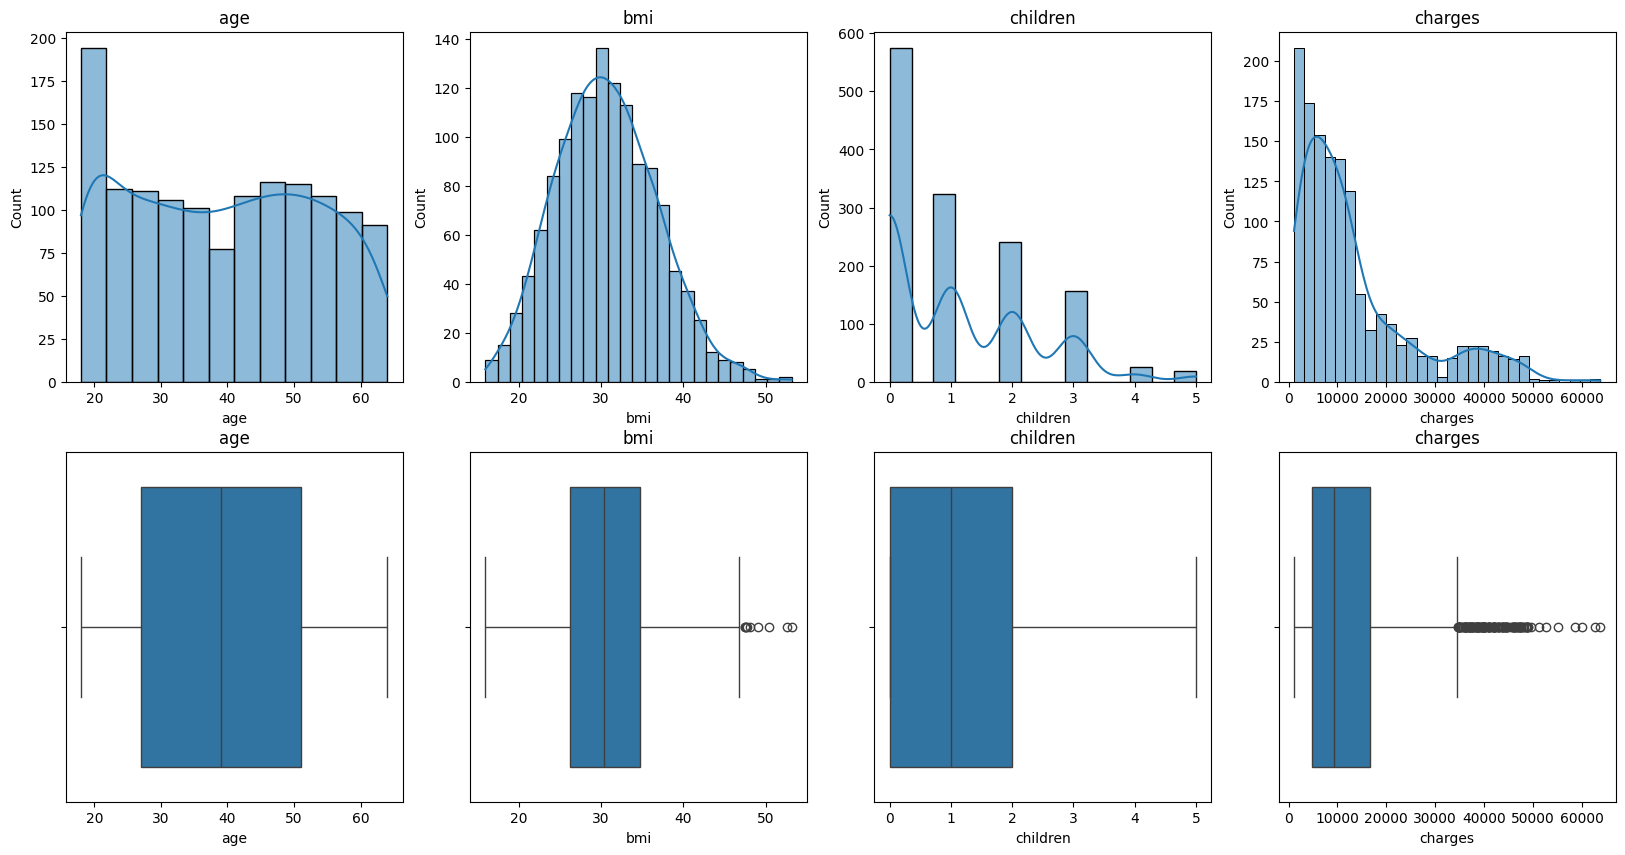

In [20]:
if num_cols:
    fig, ax = plt.subplots(2, len(num_cols), figsize=(5 * len(num_cols), 10))
    for i, c in enumerate(num_cols):
        sns.histplot(df[c], kde=True, ax=ax[0, i]); ax[0, i].set_title(c)
        sns.boxplot(x=df[c], ax=ax[1, i]); ax[1, i].set_title(c)
    plt.show()

Es de destacar que más personas en el conjunto de datos se oxigenan en sus 20 años, más no tienen hijos, el índice de masa corporal más prevalente promedia 30 IMC y las posiciones más altas oscilan entre 3000 y 10000.

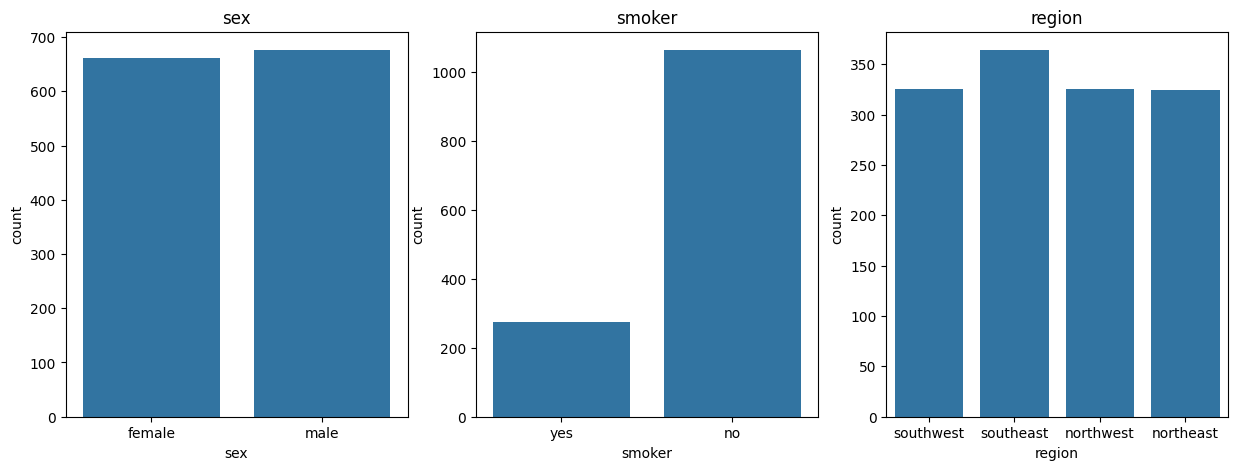

In [21]:
if cat_cols:
    fig, ax = plt.subplots(1, len(cat_cols), figsize=(5 * len(cat_cols), 5))
    if len(cat_cols) == 1: ax = [ax]
    for i, c in enumerate(cat_cols):
        sns.countplot(x=df[c], ax=ax[i]); ax[i].set_title("" + c)
    plt.show()

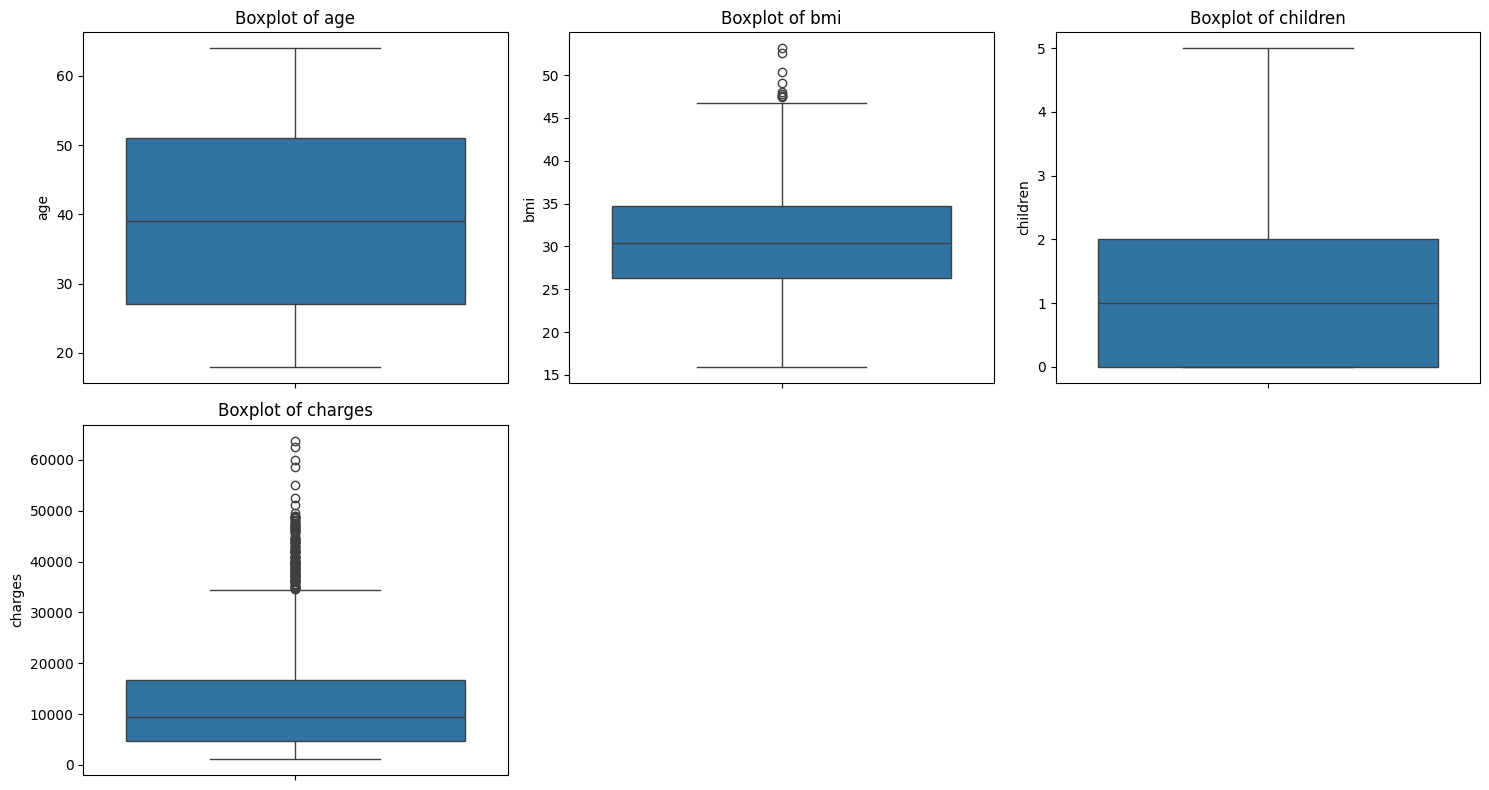

In [22]:
plt.figure(figsize=(15, 8))
for i, col in enumerate(num_cols):
    plt.subplot(2, len(num_cols)//2 + 1, i+1)
    sns.boxplot(data=df, y=col)
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

### **Identificación de Outliers**

In [23]:
Q1 = df[num_cols].quantile(0.25)
Q3 = df[num_cols].quantile(0.75)
IQR = Q3 - Q1

outlier_mask = (df[num_cols] < (Q1 - 1.5 * IQR)) | (df[num_cols] > (Q3 + 1.5 * IQR))
df_outliers_iqr = df[outlier_mask.any(axis=1)]

print(f"Número de outliers según IQR: {df_outliers_iqr.shape[0]}")


Número de outliers según IQR: 145


### **Remoción de outliers**

In [24]:
df_clean = df[~((df[num_cols] < (Q1 - 1.5 * IQR)) | (df[num_cols] > (Q3 + 1.5 * IQR))).any(axis=1)]
print(f"Dataset despues de eliminar outliers, Shape: {df_clean.shape}")

Dataset despues de eliminar outliers, Shape: (1193, 7)


Overall, the ratio of men and women is balanced, the rate of non-smokers is very significant, and the region with the largest number of employees is the Southeast.

### **Multivariate Analysis**

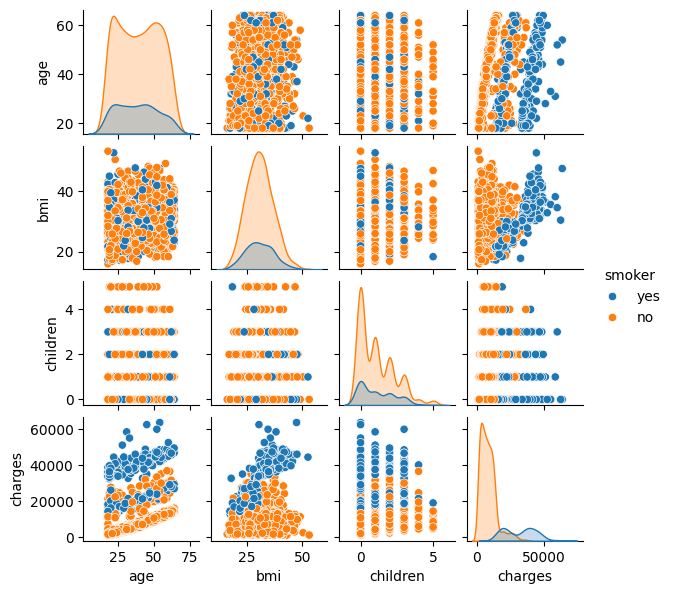

In [25]:
hue_param = 'smoker'  #@param ["age", "sex", "bmi", "smoker", "region", "charges"]

sns.pairplot(df, hue=hue_param, height=1.5)
plt.show()


### Facets are used to have a better visualization of the data.

In [ ]:
SAMPLE_SIZE = 500 #@param

df_dive = df.sample(SAMPLE_SIZE).to_json(orient='records')

HTML_TEMPLATE = """<script src="https://cdnjs.cloudflare.com/ajax/libs/webcomponentsjs/1.3.3/webcomponents-lite.js"></script>
        <link rel="import" href="https://raw.githubusercontent.com/PAIR-code/facets/1.0.0/facets-dist/facets-jupyter.html">
        <facets-dive id="elem" height="600"></facets-dive>
        <script>
          var data = {jsonstr};
          document.querySelector("#elem").data = data;
        </script>"""
html = HTML_TEMPLATE.format(jsonstr=df_dive)
display(HTML(html))

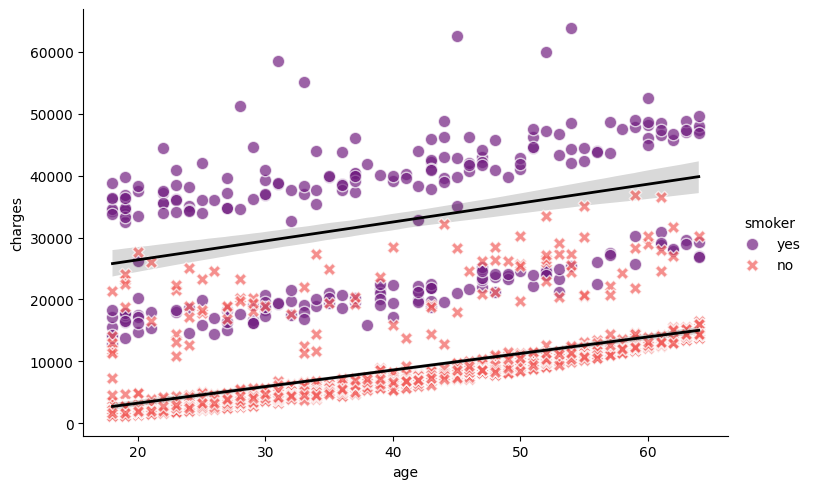

In [26]:
sns.lmplot(
    data=df,
    x="age",
    y="charges",
    hue="smoker",
    palette="magma",
    markers=["o", "X"],  # Markers for smokers and non-smokers
    line_kws={"color": "black", "linewidth": 2},  # Customizing regression line
    scatter_kws={"s": 80, "alpha": 0.7, "edgecolors": "w"},  # Customizing scatter points
    aspect=1.5  # Adjustment of the aspect ratio
)
plt.show()

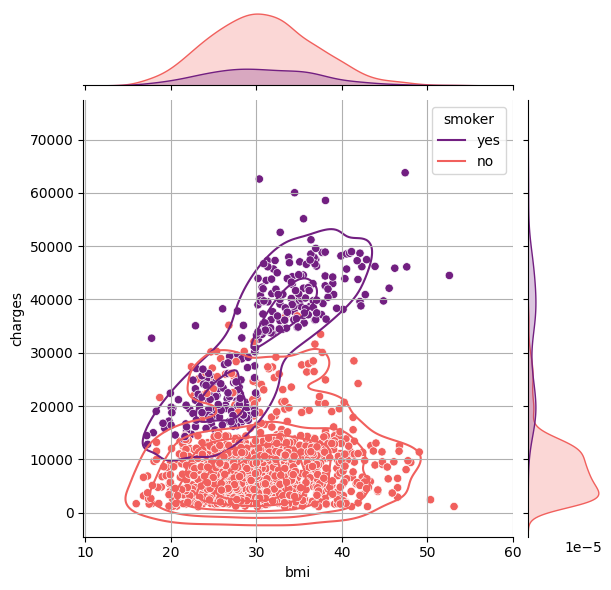

In [27]:
hue_param = "smoker"  #@param ["sex", "smoker", "children", "region_northeast", "region_northwest", "region_southeast", "region_southwest"]

if df[hue_param].dtype in [int, float]:
    hue_data = df[hue_param].astype(str)
else:
    hue_data = df[hue_param]

g = sns.jointplot(data=df, x="bmi", y="charges", hue=hue_data, kind="scatter", palette="magma")

g.plot_joint(sns.kdeplot, color="red", zorder=1, levels=6)

plt.grid(True)
plt.show()


# **INICIALIZACION DE METODOS DE ENSAMBLE PARA PROBLEMA DE REGRESION**

# **BAGGING**

*Preparacion de los datos X & y con el respectivo Dtype de columnas o features*

In [28]:
X = df.drop('charges', axis=1)
y = df['charges']

In [29]:
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object']).columns.tolist()

### **Pipeline para columnas numéricas**

In [30]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())  # RobustScaler es resistente a outliers
])

### **Pipeline para columnas categóricas**


In [31]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

### **Se combinan ambos en ColumnTransformer**

In [32]:
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_cols),
    ('cat', categorical_transformer, cat_cols)
])

# **Bagging con Árboles de Decisión como base**



In [150]:
model = BaggingRegressor(
    estimator=DecisionTreeRegressor(),
    n_estimators=50,
    random_state=100
)

In [151]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', model)
])


# **ENTRENAMIENTO Y EVALUACION DEL MODELO**

### **Split:** Train & Test

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

### **Entrenamiento del pipeline**

In [152]:
pipeline_F1 = Pipeline([
    ('fase_1', preprocessor.set_output(transform='pandas'))
])

In [153]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['age', 'bmi', 'children']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['sex', 'smoker',
                                                   'region'])])),
                ('regressor',
                 BaggingRegressor(estimator=DecisionTreeRegressor(),
                                  n_estimators=50, random_state=100))])

In [154]:
y_pred_train = pipeline.predict(X_train)
y_pred_test = pipeline.predict(X_test)

# **Evaluacion de Train**

In [155]:
mae_train = mean_absolute_error(y_train, y_pred_train)
mse_train = mean_squared_error(y_train, y_pred_train)
rmse_train = root_mean_squared_error(y_train, y_pred_train)
mape_train = mean_absolute_percentage_error(y_train, y_pred_train) * 100
r2_train = r2_score(y_train, y_pred_train)

print(" Resultados - Train:")
print("\n------------------------------------\n")
print(f"MAE:  {mae_train:.2f}")
print(f"MSE:  {mse_train:.2f}")
print(f"RMSE: {rmse_train:.2f}")
print(f"MAPE: {mape_train:.2f}%")
print(f"R²:   {r2_train:.2f}")

 Resultados - Train:

------------------------------------

MAE:  1058.48
MSE:  3885525.56
RMSE: 1971.17
MAPE: 13.01%
R²:   0.97


# **Evaluacion de Test**

In [156]:
mae_test = mean_absolute_error(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = root_mean_squared_error(y_test, y_pred_test)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test) * 100
r2_test = r2_score(y_test, y_pred_test)

print("\n Resultados - Test:")
print("\n------------------------------------\n")
print(f"MAE:  {mae_test:.2f}")
print(f"MSE:  {mse_test:.2f}")
print(f"RMSE: {rmse_test:.2f}")
print(f"MAPE: {mape_test:.2f}%")
print(f"R²:   {r2_test:.2f}")


 Resultados - Test:

------------------------------------

MAE:  2657.48
MSE:  19274042.65
RMSE: 4390.22
MAPE: 30.68%
R²:   0.88


### **Linea de regresion para Train**

In [41]:
min_val_train = min(y_train.min(), y_pred_train.min())
max_val_train = max(y_train.max(), y_pred_train.max())

fig_train = go.Figure(data=[
    go.Scatter(x=y_train.values, y=y_pred_train, mode='markers', name='BaggingRegressor',
               marker=dict(color='purple', opacity=0.6, size=7)),
    go.Scatter(x=[min_val_train, max_val_train], y=[min_val_train, max_val_train],
               mode='lines', name='Ideal', line=dict(color='black', dash='dash'))
])

fig_train.update_yaxes(range=[min_val_train, max_val_train])
fig_train.update_xaxes(range=[min_val_train, max_val_train])
fig_train.update_layout(title="📈 Performance del Modelo - Entrenamiento (Train)",
                        xaxis_title="Cargos reales (charges)",
                        yaxis_title="Cargos predichos",
                        width=700, height=500,
                        template="plotly_white")
fig_train.show()


### **Calculo de residuos Train vs predicciones**

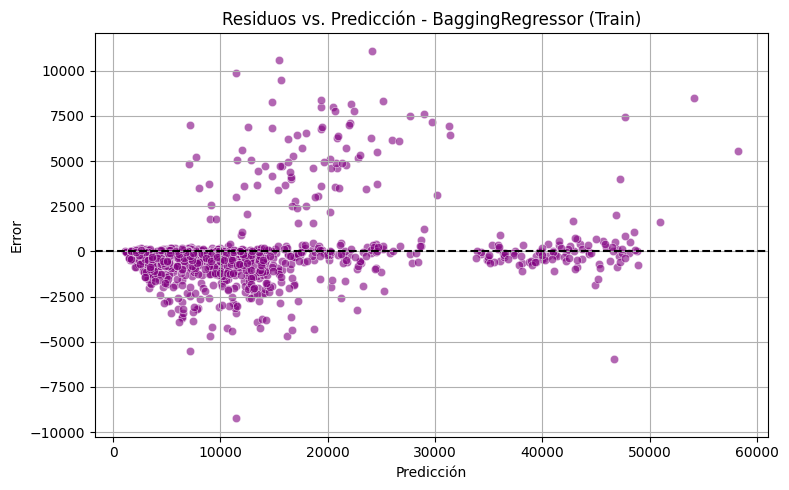

In [44]:
residuals_train = y_train - y_pred_train

plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_pred_train, y=residuals_train, alpha=0.6, color='blue')
plt.axhline(0, linestyle='--', color='black')
plt.title('Residuos vs. Predicción - BaggingRegressor (Train)')
plt.xlabel('Predicción')
plt.ylabel('Error')
plt.grid(True)
plt.tight_layout()
plt.show()


### **Linea de regresion para Test**

In [43]:
min_val_test = min(y_test.min(), y_pred_test.min())
max_val_test = max(y_test.max(), y_pred_test.max())

fig_test = go.Figure(data=[
    go.Scatter(x=y_test.values, y=y_pred_test, mode='markers', name='BaggingRegressor',
               marker=dict(color='blue', opacity=0.6, size=7)),
    go.Scatter(x=[min_val_test, max_val_test], y=[min_val_test, max_val_test],
               mode='lines', name='Ideal', line=dict(color='red', dash='dash'))
])

fig_test.update_yaxes(range=[min_val_test, max_val_test])
fig_test.update_xaxes(range=[min_val_test, max_val_test])
fig_test.update_layout(title="📈 Performance del Modelo - Prueba (Test)",
                       xaxis_title="Cargos reales (charges)",
                       yaxis_title="Cargos predichos",
                       width=700, height=500,
                       template="plotly_white")
fig_test.show()

### **Calculo de residuos Test vs predicciones**

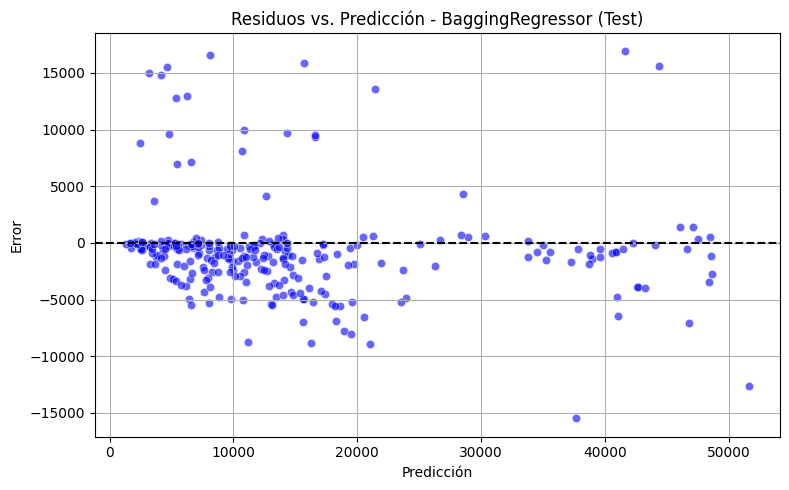

In [47]:
residuals_test = y_test - y_pred_test

plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_pred_test, y=residuals_test, alpha=0.6, color='blue')
plt.axhline(0, linestyle='--', color='black')
plt.title('Residuos vs. Predicción - BaggingRegressor (Test)')
plt.xlabel('Predicción')
plt.ylabel('Error')
plt.grid(True)
plt.tight_layout()
plt.show()

# **Validacion cruzada** *BAGGING*

In [169]:
cv_results = cross_validate(
    estimator=pipeline,
    X=X,
    y=y,
    scoring={
        'r2': 'r2',
        'mae': 'neg_mean_absolute_error',
        'rmse': 'neg_root_mean_squared_error',
        'mape': 'neg_mean_absolute_percentage_error'
    },
    cv=5,
    n_jobs=-1,
    return_train_score=False
)

print("Validación cruzada con BaggingRegressor:\n")
for metric in ['r2', 'mae', 'rmse', 'mape']:
    mean = np.mean(cv_results[f'test_{metric}'])
    std = np.std(cv_results[f'test_{metric}'])

    if metric != 'r2':
        mean = -mean

    print(f"{metric.upper()} CV: {mean:.2f} ± {std:.2f}")


Validación cruzada con BaggingRegressor:

R2 CV: 0.84 ± 0.04
MAE CV: 2660.79 ± 198.41
RMSE CV: 4858.49 ± 391.26
MAPE CV: 0.31 ± 0.02


In [170]:
comparison_df = pd.DataFrame({
    'Real': y_test.values,
    'Predicted': y_pred_test
})
comparison_df.head(10)

,Real,Predicted
0,1826.84300,4888.144408
1,20177.67113,4617.852844
2,7421.19455,16266.576587
3,1877.92940,2508.309000
4,15518.18025,16931.148984
5,29523.16560,28986.522085
6,13143.86485,13230.216321
7,3279.86855,6480.256240
8,18972.49500,19417.427868
9,12950.07120,13308.720329


# PREDICCIONES CON **Bagging**

In [171]:
#Sample row
print(df.iloc[133])

age                 19
sex               male
bmi             25.555
children             0
smoker              no
region       northwest
charges     1632.56445
Name: 133, dtype: object


In [172]:
#@title Sample Patient John Doe - Features Input { run: "auto" }
age = 19           #@param {type:"integer"}
sex = "male"     #@param ["female", "male"]
bmi = 25.555        #@param {type:"number"}
children = 0       #@param {type:"integer"}
smoker = "no"     #@param ["yes", "no"]
region = "northwest" #@param ["southeast", "northwest", "southwest", "northeast"]


# Input como diccionario
input_dict = {
    'age': [age],
    'sex': [sex],
    'bmi': [bmi],
    'children': [children],
    'smoker': [smoker],
    'region': [region]
}

# Convertir a DataFrame
input_df = pd.DataFrame(input_dict)

predicted_charge = pipeline.predict(input_df)

# Mostrar el resultado
print(f"Predicción de gastos médicos: ${predicted_charge[0]:,.2f}")


Predicción de gastos médicos: $1,632.17


# Analizando los resultados, vemos que el modelo tiende a explicar un 84% de la varianza, sin embargo, haciendo pruebas, el modelo parece estar teniendo un alto nivel predictorio conforme a los datos vistos y no vistos, muestra un balance, el R2 en training muestra un 97% de explicabilidad de la varianza y en Testing muestra un 88%.

_____________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________

# **BOOSTING**

## Boosting con **LightGradientBoostingMachine** como base

In [173]:
model = LGBMRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=-1,
    random_state=100
)

# **ENTRENAMIENTO Y EVALUACION DEL MODELO**

In [175]:
pipeline = Pipeline([
    ('preprocessor', preprocessor.set_output(transform='pandas')),
    ('regressor', model)
])

### **Entrenamiento del pipeline**

In [176]:
pipeline.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000360 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 324
[LightGBM] [Info] Number of data points in the train set: 1070, number of used features: 11
[LightGBM] [Info] Start training from score 13064.896362


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['age', 'bmi', 'children']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['sex', 'smoker',
                                                   'region'])])),
                ('regressor', LGBMRegressor(random_state=100))])

In [177]:
y_pred_train = pipeline.predict(X_train)
y_pred_test = pipeline.predict(X_test)

# **Evaluacion de Train**

In [178]:
mae_train = mean_absolute_error(y_train, y_pred_train)
mse_train = mean_squared_error(y_train, y_pred_train)
rmse_train = root_mean_squared_error(y_train, y_pred_train)
mape_train = mean_absolute_percentage_error(y_train, y_pred_train) * 100
r2_train = r2_score(y_train, y_pred_train)

print(" Resultados - Train:")
print("\n------------------------------------\n")
print(f"MAE:  {mae_train:.2f}")
print(f"MSE:  {mse_train:.2f}")
print(f"RMSE: {rmse_train:.2f}")
print(f"MAPE: {mape_train:.2f}%")
print(f"R²:   {r2_train:.2f}")

 Resultados - Train:

------------------------------------

MAE:  1768.02
MSE:  8932633.04
RMSE: 2988.75
MAPE: 23.07%
R²:   0.94


# **Evaluacion de Test**

In [179]:
mae_test = mean_absolute_error(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = root_mean_squared_error(y_test, y_pred_test)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test) * 100
r2_test = r2_score(y_test, y_pred_test)

print("\n Resultados - Test:")
print("\n------------------------------------\n")
print(f"MAE:  {mae_test:.2f}")
print(f"MSE:  {mse_test:.2f}")
print(f"RMSE: {rmse_test:.2f}")
print(f"MAPE: {mape_test:.2f}%")
print(f"R²:   {r2_test:.2f}")


 Resultados - Test:

------------------------------------

MAE:  2721.02
MSE:  18570750.55
RMSE: 4309.38
MAPE: 34.30%
R²:   0.88


### Resultados muy similares a los del metodo Bagging, procedemos a hacer un **Grid Search**, indicando el **Param Grid** para optimizar el modelo.

### **Param_grid**

In [180]:
param_grid = {
    'regressor__n_estimators': [50, 100, 200],
    'regressor__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'regressor__max_depth': [-1, 3, 5, 7, 10],
    'regressor__num_leaves': [15, 31, 50],
    'regressor__min_child_samples': [5, 10, 20],
    'regressor__subsample': [0.6, 0.8, 1.0],
    'regressor__colsample_bytree': [0.6, 0.8, 1.0]
}


In [182]:
grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring={
        'r2': 'r2',
        'mae': 'neg_mean_absolute_error',
        'rmse': 'neg_root_mean_squared_error',
        'mape': 'neg_mean_absolute_percentage_error'
    },
    cv=5,
    n_jobs=-1,
    verbose=2,
    refit='rmse'
)

grid.fit(X_train, y_train)
#Debido a la cantidad de hiperparametros en el ParamGrid, este codigo demora 30 minutos en ejecutarse.

Fitting 5 folds for each of 4860 candidates, totalling 24300 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000127 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 324
[LightGBM] [Info] Number of data points in the train set: 1070, number of used features: 11
[LightGBM] [Info] Start training from score 13064.896362
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          RobustScaler())]),
                                                                         ['age',
                                                                          'bmi',
                                                                          'children']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse_outpu...
                         'regressor__learning_rate': [0.01, 0.05, 0.1, 0.2],
                         'regressor__max_depth': [-1, 3, 5, 7, 10],
                         'regressor__min_child_samples': [5, 10, 20],
                         'regressor__n_estimators': [50, 100, 200],
                         'regressor__num_leaves': [15, 31, 50],
                         'regressor__subsample': [0.6, 0.8, 1.0]},
             refit='rmse',
             scoring={'mae': 'neg_mean_absolute_error',
                      'mape': 'neg_mean_absolute_percentage_error', 'r2': 'r2',
                      'rmse': 'neg_root_mean_squared_error'},
             verbose=2)

In [183]:
best_model = grid.best_estimator_

In [184]:
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

### Resultados del **GridSearch** por Training

In [185]:
mae_train = mean_absolute_error(y_train, y_pred_train)
mse_train = mean_squared_error(y_train, y_pred_train)
rmse_train = root_mean_squared_error(y_train, y_pred_train)
mape_train = mean_absolute_percentage_error(y_train, y_pred_train) * 100
r2_train = r2_score(y_train, y_pred_train)

print(" Resultados - Train:")
print("\n------------------------------------\n")
print(f"MAE:  {mae_train:.2f}")
print(f"MSE:  {mse_train:.2f}")
print(f"RMSE: {rmse_train:.2f}")
print(f"MAPE: {mape_train:.2f}%")
print(f"R²:   {r2_train:.2f}")

 Resultados - Train:

------------------------------------

MAE:  2372.07
MSE:  18531259.20
RMSE: 4304.79
MAPE: 29.68%
R²:   0.87


### Resultados del **GridSearch** por Test

In [186]:
mae_test = mean_absolute_error(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = root_mean_squared_error(y_test, y_pred_test)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test) * 100
r2_test = r2_score(y_test, y_pred_test)

print("\n Resultados - Test:")
print("\n------------------------------------\n")
print(f"MAE:  {mae_test:.2f}")
print(f"MSE:  {mse_test:.2f}")
print(f"RMSE: {rmse_test:.2f}")
print(f"MAPE: {mape_test:.2f}%")
print(f"R²:   {r2_test:.2f}")


 Resultados - Test:

------------------------------------

MAE:  2349.78
MSE:  15558265.02
RMSE: 3944.40
MAPE: 28.05%
R²:   0.90


In [188]:
cv_results = cross_validate(
    estimator=grid.best_estimator_,
    X=X,
    y=y,
    scoring={
        'r2': 'r2',
        'mae': 'neg_mean_absolute_error',
        'rmse': 'neg_root_mean_squared_error',
        'mape': 'neg_mean_absolute_percentage_error'
    },
    cv=5,
    n_jobs=-1,
    return_train_score=False
)

print("Validación cruzada con BoostingRegressor - GridSearch:\n")
for metric in ['r2', 'mae', 'rmse', 'mape']:
    mean = np.mean(cv_results[f'test_{metric}'])
    std = np.std(cv_results[f'test_{metric}'])

    if metric != 'r2':
        mean = -mean

    print(f"{metric.upper()} CV: {mean:.2f} ± {std:.2f}")


Validación cruzada con BoostingRegressor - GridSearch:

R2 CV: 0.86 ± 0.03
MAE CV: 2467.24 ± 145.65
RMSE CV: 4448.17 ± 363.51
MAPE CV: 0.30 ± 0.02


In [187]:
comparison_df = pd.DataFrame({
    'Real': y_test.values,
    'Predicted': y_pred_test
})
comparison_df.head(10)

,Real,Predicted
0,1826.84300,4482.396627
1,20177.67113,5979.057826
2,7421.19455,9489.866691
3,1877.92940,3094.656962
4,15518.18025,16658.880504
5,29523.16560,27398.346746
6,13143.86485,14597.835832
7,3279.86855,6293.338309
8,18972.49500,20179.420760
9,12950.07120,14042.265361


### **Linea de regresion para Train, despues del GridSearch**

In [189]:
min_val_train = min(y_train.min(), y_pred_train.min())
max_val_train = max(y_train.max(), y_pred_train.max())

fig_train = go.Figure(data=[
    go.Scatter(x=y_train.values, y=y_pred_train, mode='markers', name='BoostingRegressor',
               marker=dict(color='black', opacity=0.6, size=7)),
    go.Scatter(x=[min_val_train, max_val_train], y=[min_val_train, max_val_train],
               mode='lines', name='Ideal', line=dict(color='red', dash='dash'))
])

fig_train.update_yaxes(range=[min_val_train, max_val_train])
fig_train.update_xaxes(range=[min_val_train, max_val_train])
fig_train.update_layout(title="📈 Performance del Modelo - Entrenamiento (Train)",
                        xaxis_title="Cargos reales (charges)",
                        yaxis_title="Cargos predichos",
                        width=700, height=500,
                        template="plotly_white")
fig_train.show()


### **Linea de regresion para Test, despues del GridSearch**

In [190]:
min_val_test = min(y_test.min(), y_pred_test.min())
max_val_test = max(y_test.max(), y_pred_test.max())

fig_test = go.Figure(data=[
    go.Scatter(x=y_test.values, y=y_pred_test, mode='markers', name='BaggingRegressor',
               marker=dict(color='red', opacity=0.6, size=7)),
    go.Scatter(x=[min_val_test, max_val_test], y=[min_val_test, max_val_test],
               mode='lines', name='Ideal', line=dict(color='black', dash='dash'))
])

fig_test.update_yaxes(range=[min_val_test, max_val_test])
fig_test.update_xaxes(range=[min_val_test, max_val_test])
fig_test.update_layout(title="📈 Performance del Modelo - Prueba (Test)",
                       xaxis_title="Cargos reales (charges)",
                       yaxis_title="Cargos predichos",
                       width=700, height=500,
                       template="plotly_white")
fig_test.show()

# **Plot de Residuos**

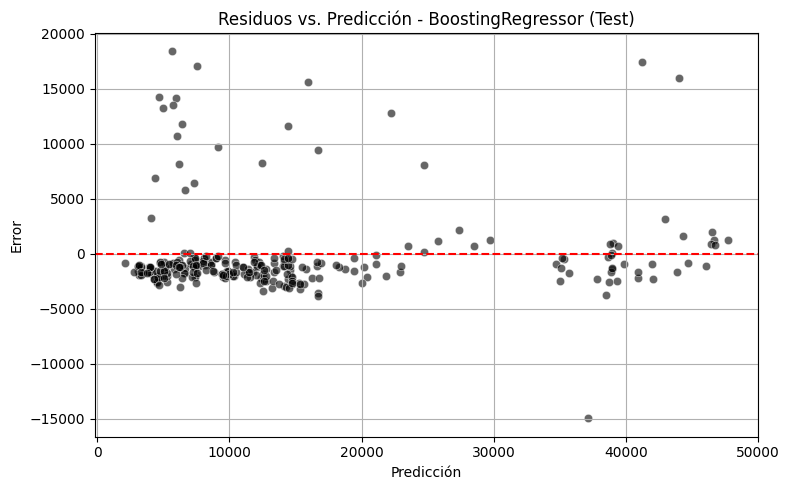

In [70]:
residuals_test = y_test - y_pred_test

plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_pred_test, y=residuals_test, alpha=0.6, color='black')
plt.axhline(0, linestyle='--', color='red')
plt.title('Residuos vs. Predicción - BoostingRegressor (Test)')
plt.xlabel('Predicción')
plt.ylabel('Error')
plt.grid(True)
plt.tight_layout()
plt.show()

# Despues del **GridSearch** Se evidencia un incremento significativo en el **Test** de 88% paso a 90% en R^2, y una disminucion de 10% en training, pasando de 94% a 87% conforme al metodo boosting con LightGradientRegressor

# PREDICCIONES CON **Boosting**

In [191]:
#Sample row
print(df.iloc[222])

age                32
sex              male
bmi              30.8
children            3
smoker             no
region      southwest
charges      5253.524
Name: 222, dtype: object


In [192]:
#@title Sample Patient John Doe - Features Input { run: "auto" }
age = 32           #@param {type:"integer"}
sex = "male"     #@param ["female", "male"]
bmi = 30.8        #@param {type:"number"}
children = 3       #@param {type:"integer"}
smoker = "no"     #@param ["yes", "no"]
region = "southwest" #@param ["southeast", "northwest", "southwest", "northeast"]


# Input como diccionario
input_dict = {
    'age': [age],
    'sex': [sex],
    'bmi': [bmi],
    'children': [children],
    'smoker': [smoker],
    'region': [region]
}

# Convertir a DataFrame
input_df = pd.DataFrame(input_dict)

predicted_charge = pipeline.predict(input_df)

# Mostrar el resultado
print(f"Predicción de gastos médicos: ${predicted_charge[0]:,.2f}")


Predicción de gastos médicos: $3,795.15


# Observamos el impacto que tuvo en las predicciones la disminucion de las metricas conforme al metodo boosting y despues del GridSearch.

Conforme a este input, el modelo debio haber predicho 5253.524, en lugar de esto, predijo 3795.15

Por tal motivo, el modelo presenta mejores resultados con el metodo **Bagging**.



---



## Utilizamos **RandomizedSearchCV**, para observar si podemos mejorar resultados en **Boosting** con LightGBM.

### Para ello, configuramos los parametros de busqueda aleatoria y el RandomizedSearch

### **Param Distribution**

In [193]:
param_dist = {
    'regressor__n_estimators': randint(50, 300),
    'regressor__learning_rate': uniform(0.01, 0.3),
    'regressor__max_depth': randint(3, 10),
    'regressor__num_leaves': randint(20, 80),
    'regressor__min_child_samples': randint(5, 30),
    'regressor__subsample': uniform(0.6, 0.4),
    'regressor__colsample_bytree': uniform(0.6, 0.4)
}


## **RandomizedSearchCV**

In [195]:
RS_LGBM = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=100,
    scoring={
        'r2': 'r2',
        'mae': 'neg_mean_absolute_error',
        'rmse': 'neg_root_mean_squared_error',
        'mape': 'neg_mean_absolute_percentage_error'
    },
    refit='r2',
    cv=5,
    n_jobs=-1,
    verbose=2,
    random_state=100
)


### Entrenamiento del modelo

In [196]:
RS_LGBM.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000084 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 324
[LightGBM] [Info] Number of data points in the train set: 1070, number of used features: 11
[LightGBM] [Info] Start training from score 13064.896362
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                RobustScaler())]),
                                                                               ['age',
                                                                                'bmi',
                                                                                'children']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('encoder',
                                                                                                OneHotEncoder(handle_unknown='ignore',
                                                                                                              sparse...
                                        'regressor__num_leaves': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x797e362c7c50>,
                                        'regressor__subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x797e3503ddd0>},
                   random_state=100, refit='r2',
                   scoring={'mae': 'neg_mean_absolute_error',
                            'mape': 'neg_mean_absolute_percentage_error',
                            'r2': 'r2', 'rmse': 'neg_root_mean_squared_error'},
                   verbose=2)

### Mejores Parametros encontrados por el **RandomizedSearchCV**

In [197]:
print("Mejores parámetros encontrados:")
print(RS_LGBM.best_params_)

Mejores parámetros encontrados:
{'regressor__colsample_bytree': np.float64(0.9581890429837594), 'regressor__learning_rate': np.float64(0.03485090839778489), 'regressor__max_depth': 3, 'regressor__min_child_samples': 22, 'regressor__n_estimators': 146, 'regressor__num_leaves': 40, 'regressor__subsample': np.float64(0.660560074611656)}


### **Mejor Modelo**

In [198]:
best_model = RS_LGBM.best_estimator_

### **Predicciones**

In [199]:
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

### Resultados del **RandomizedSearchCV** por Training

In [200]:
mae_train = mean_absolute_error(y_train, y_pred_train)
mse_train = mean_squared_error(y_train, y_pred_train)
rmse_train = root_mean_squared_error(y_train, y_pred_train)
mape_train = mean_absolute_percentage_error(y_train, y_pred_train) * 100
r2_train = r2_score(y_train, y_pred_train)

print(" Resultados - Train:")
print("\n------------------------------------\n")
print(f"MAE:  {mae_train:.2f}")
print(f"MSE:  {mse_train:.2f}")
print(f"RMSE: {rmse_train:.2f}")
print(f"MAPE: {mape_train:.2f}%")
print(f"R²:   {r2_train:.2f}")

 Resultados - Train:

------------------------------------

MAE:  2380.06
MSE:  18608933.89
RMSE: 4313.81
MAPE: 29.76%
R²:   0.87


### Resultados del **RandomizedSearchCV** por Test

In [201]:
mae_test = mean_absolute_error(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = root_mean_squared_error(y_test, y_pred_test)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test) * 100
r2_test = r2_score(y_test, y_pred_test)

print("\n Resultados - Test:")
print("\n------------------------------------\n")
print(f"MAE:  {mae_test:.2f}")
print(f"MSE:  {mse_test:.2f}")
print(f"RMSE: {rmse_test:.2f}")
print(f"MAPE: {mape_test:.2f}%")
print(f"R²:   {r2_test:.2f}")


 Resultados - Test:

------------------------------------

MAE:  2341.69
MSE:  15478861.50
RMSE: 3934.32
MAPE: 27.99%
R²:   0.90


### **Linea de regresion para Train, despues del RandomizedSearch**

In [202]:
min_val_train = min(y_train.min(), y_pred_train.min())
max_val_train = max(y_train.max(), y_pred_train.max())

fig_train = go.Figure(data=[
    go.Scatter(x=y_train.values, y=y_pred_train, mode='markers', name='BoostingRegressor',
               marker=dict(color='black', opacity=0.6, size=7)),
    go.Scatter(x=[min_val_train, max_val_train], y=[min_val_train, max_val_train],
               mode='lines', name='Ideal', line=dict(color='red', dash='dash'))
])

fig_train.update_yaxes(range=[min_val_train, max_val_train])
fig_train.update_xaxes(range=[min_val_train, max_val_train])
fig_train.update_layout(title="📈 Performance del Modelo - Entrenamiento (Train)",
                        xaxis_title="Cargos reales (charges)",
                        yaxis_title="Cargos predichos",
                        width=700, height=500,
                        template="plotly_white")
fig_train.show()

### **Linea de regresion para Test, despues del RandomizedSearch**

In [203]:
min_val_test = min(y_test.min(), y_pred_test.min())
max_val_test = max(y_test.max(), y_pred_test.max())

fig_test = go.Figure(data=[
    go.Scatter(x=y_test.values, y=y_pred_test, mode='markers', name='BaggingRegressor',
               marker=dict(color='blue', opacity=0.6, size=7)),
    go.Scatter(x=[min_val_test, max_val_test], y=[min_val_test, max_val_test],
               mode='lines', name='Ideal', line=dict(color='black', dash='dash'))
])

fig_test.update_yaxes(range=[min_val_test, max_val_test])
fig_test.update_xaxes(range=[min_val_test, max_val_test])
fig_test.update_layout(title="📈 Performance del Modelo - Prueba (Test)",
                       xaxis_title="Cargos reales (charges)",
                       yaxis_title="Cargos predichos",
                       width=700, height=500,
                       template="plotly_white")
fig_test.show()

### **Plot de residuos**

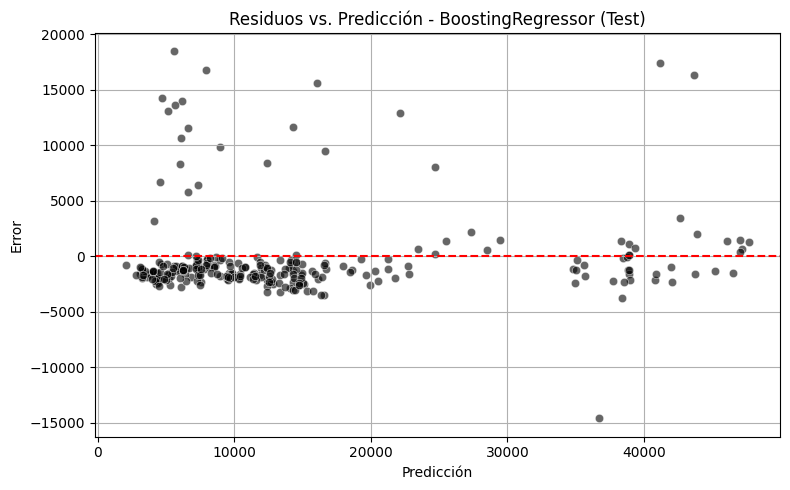

In [204]:
residuals_test = y_test - y_pred_test

plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_pred_test, y=residuals_test, alpha=0.6, color='black')
plt.axhline(0, linestyle='--', color='red')
plt.title('Residuos vs. Predicción - BoostingRegressor (Test)')
plt.xlabel('Predicción')
plt.ylabel('Error')
plt.grid(True)
plt.tight_layout()
plt.show()

In [205]:
comparison_df = pd.DataFrame({
    'Real': y_test.values,
    'Predicted': y_pred_test
})
comparison_df.head(10)

,Real,Predicted
0,1826.84300,4290.289542
1,20177.67113,6168.713955
2,7421.19455,9485.588764
3,1877.92940,3188.525286
4,15518.18025,16697.152957
5,29523.16560,27352.407969
6,13143.86485,14848.342576
7,3279.86855,6080.986454
8,18972.49500,20305.702341
9,12950.07120,14279.962272


# **Validacion Cruzada** *Boosting*

In [209]:
cv_results = cross_validate(
    estimator=best_model,
    X=X, y=y,
    cv=5,
    scoring={
        'r2': 'r2',
        'mae': 'neg_mean_absolute_error',
        'rmse': 'neg_root_mean_squared_error',
        'mape': 'neg_mean_absolute_percentage_error'
    },
    n_jobs=-1
)

print(f"R² por validación cruzada: {cv_results['test_r2']}")
print(f"Promedio R² CV: {np.mean(cv_results['test_r2']):.3f} ± {np.std(cv_results['test_r2']):.3f}")

R² por validación cruzada: [0.88523416 0.81028481 0.89578145 0.85257754 0.86818755]
Promedio R² CV: 0.862 ± 0.030


# PREDICCIONES CON **Boosting** despues del Fine-Tuning con GridSearch

In [221]:
#Sample row
print(df.iloc[333])

age                  56
sex              female
bmi              28.785
children              0
smoker               no
region        northeast
charges     11658.37915
Name: 333, dtype: object


In [228]:
#@title Sample Patient John Doe - Features Input { run: "auto" }
age = 56           #@param {type:"integer"}
sex = "female"     #@param ["female", "male"]
bmi = 28.785        #@param {type:"number"}
children = 0       #@param {type:"integer"}
smoker = "no"     #@param ["yes", "no"]
region = "northeast" #@param ["southeast", "northwest", "southwest", "northeast"]


# Input como diccionario
input_dict = {
    'age': [age],
    'sex': [sex],
    'bmi': [bmi],
    'children': [children],
    'smoker': [smoker],
    'region': [region]
}

# Convertir a DataFrame
input_df = pd.DataFrame(input_dict)

predicted_charge = pipeline.predict(input_df)

# Mostrar el resultado
print(f"Predicción de gastos médicos: ${predicted_charge[0]:,.2f}")


Predicción de gastos médicos: $10,606.19


# Observamos que los resultados del **RandomizedSearch**, se asemejan a los previous arrojados por el **GridSearch**, sin embargo, en este ultimo se observa una leve mejoria en la generalizacion de la data.

## De igual manera, frente a las predicciones arrojadas durante el testeo, el Medodo **Bagging** muestra un comportamiento superior en la presicion de las predicciones.



---



# **STACKING**

# Algoritmos Aplicados:

## 1) **RandomForestRegressor**,
## 2) **GradientBoostingRegressor**,
## 3) **SupportVectorRegressor**
## 4) **KNeighborsRegressor**

### **Estimadores/Algoritmos**

In [231]:
estimators = [
    ('rf', RandomForestRegressor(random_state=100)),
    ('gb', GradientBoostingRegressor(random_state=100)),
    ('svr', SVR()),
    ('knn', KNeighborsRegressor())
]

In [232]:
stacking_model = StackingRegressor(
    estimators=estimators,
    final_estimator=Ridge(),
    cv=5,
    n_jobs=-1
)

### **Pipeline Stacking**

In [233]:
pipeline_stack = Pipeline([
    ('preprocessor', preprocessor.set_output(transform='pandas')),
    ('regressor', stacking_model)
])

### **Entrenamiento del modelo Stacking**

In [234]:
pipeline_stack.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['age', 'bmi', 'children']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['sex', 'smoker',
                                                   'region'])])),
                ('regressor',
                 StackingRegressor(cv=5,
                                   estimators=[('rf',
                                                RandomForestRegressor(random_state=100)),
                                               ('gb',
                                                GradientBoostingRegressor(random_state=100)),
                                               ('svr', SVR()),
                                               ('knn', KNeighborsRegressor())],
                                   final_estimator=Ridge(), n_jobs=-1))])

### **Predicciones PipelineStacking**

In [235]:
y_pred_train = pipeline_stack.predict(X_train)
y_pred_test = pipeline_stack.predict(X_test)

### **Resultados por Train** *Stacking*

In [236]:
mae_train = mean_absolute_error(y_train, y_pred_train)
mse_train = mean_squared_error(y_train, y_pred_train)
rmse_train = root_mean_squared_error(y_train, y_pred_train)
mape_train = mean_absolute_percentage_error(y_train, y_pred_train) * 100
r2_train = r2_score(y_train, y_pred_train)

print(" Resultados - Train:")
print("\n------------------------------------\n")
print(f"MAE:  {mae_train:.2f}")
print(f"MSE:  {mse_train:.2f}")
print(f"RMSE: {rmse_train:.2f}")
print(f"MAPE: {mape_train:.2f}%")
print(f"R²:   {r2_train:.2f}")

 Resultados - Train:

------------------------------------

MAE:  1925.09
MSE:  12648829.82
RMSE: 3556.52
MAPE: 22.00%
R²:   0.91


### **Resultados por Test** *Stacking*

In [237]:
mae_test = mean_absolute_error(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = root_mean_squared_error(y_test, y_pred_test)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test) * 100
r2_test = r2_score(y_test, y_pred_test)

print("\n Resultados - Test:")
print("\n------------------------------------\n")
print(f"MAE:  {mae_test:.2f}")
print(f"MSE:  {mse_test:.2f}")
print(f"RMSE: {rmse_test:.2f}")
print(f"MAPE: {mape_test:.2f}%")
print(f"R²:   {r2_test:.2f}")


 Resultados - Test:

------------------------------------

MAE:  2343.52
MSE:  15796094.67
RMSE: 3974.43
MAPE: 26.51%
R²:   0.90


# **Validacion cruzada**

In [238]:
cv_results = cross_validate(
    estimator=pipeline_stack,
    X=X,
    y=y,
    scoring={
        'r2': 'r2',
        'mape': 'neg_mean_absolute_percentage_error',
        'mae': 'neg_mean_absolute_error',
        'rmse': 'neg_root_mean_squared_error'
    },
    cv=5,
    return_train_score=True,
    n_jobs=-1
)

for metric in ['r2', 'mae', 'rmse', 'mape']:
    mean = np.mean(cv_results[f'test_{metric}'])
    std = np.std(cv_results[f'test_{metric}'])

    if metric != 'r2':
        mean = -mean

    print(f"{metric.upper()} CV: {mean:.2f} ± {std:.2f}")


R2 CV: 0.86 ± 0.03
MAE CV: 2479.97 ± 166.83
RMSE CV: 4559.29 ± 341.72
MAPE CV: 0.28 ± 0.02


### **Analisis de datos reales vs predichos**

In [239]:
comparison_df = pd.DataFrame({
    'Real': y_test.values,
    'Predicted': y_pred_test
})
comparison_df.head(10)

,Real,Predicted
0,1826.84300,3980.430312
1,20177.67113,5822.868086
2,7421.19455,11165.235124
3,1877.92940,2806.998881
4,15518.18025,17415.574568
5,29523.16560,28388.580564
6,13143.86485,14528.319666
7,3279.86855,6301.558137
8,18972.49500,20881.711730
9,12950.07120,14655.726154


### **Linea de regresion para Train**

In [240]:
min_val_train = min(y_train.min(), y_pred_train.min())
max_val_train = max(y_train.max(), y_pred_train.max())

fig_train = go.Figure(data=[
    go.Scatter(x=y_train.values, y=y_pred_train, mode='markers', name='StackingRegressor',
               marker=dict(color='purple', opacity=0.6, size=7)),
    go.Scatter(x=[min_val_train, max_val_train], y=[min_val_train, max_val_train],
               mode='lines', name='Ideal', line=dict(color='black', dash='dash'))
])

fig_train.update_yaxes(range=[min_val_train, max_val_train])
fig_train.update_xaxes(range=[min_val_train, max_val_train])
fig_train.update_layout(title="📈 Performance del Modelo - Entrenamiento (Train)",
                        xaxis_title="Cargos reales (charges)",
                        yaxis_title="Cargos predichos",
                        width=700, height=500,
                        template="plotly_white")
fig_train.show()

### **Linea de regresion para Test**

In [241]:
min_val_test = min(y_test.min(), y_pred_test.min())
max_val_test = max(y_test.max(), y_pred_test.max())

fig_test = go.Figure(data=[
    go.Scatter(x=y_test.values, y=y_pred_test, mode='markers', name='BaggingRegressor',
               marker=dict(color='blue', opacity=0.6, size=7)),
    go.Scatter(x=[min_val_test, max_val_test], y=[min_val_test, max_val_test],
               mode='lines', name='Ideal', line=dict(color='black', dash='dash'))
])

fig_test.update_yaxes(range=[min_val_test, max_val_test])
fig_test.update_xaxes(range=[min_val_test, max_val_test])
fig_test.update_layout(title="📈 Performance del Modelo - Prueba (Test)",
                       xaxis_title="Cargos reales (charges)",
                       yaxis_title="Cargos predichos",
                       width=700, height=500,
                       template="plotly_white")
fig_test.show()

### **Visualizacion de datos residuales vs predichos**

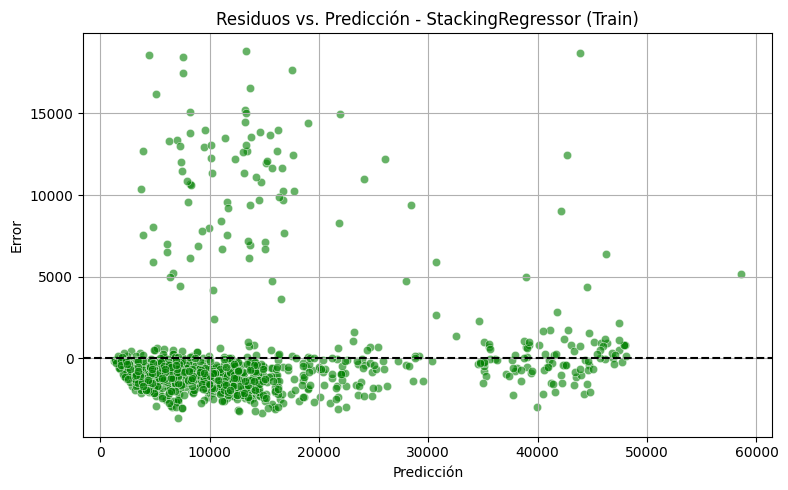

In [242]:
residuals_train = y_train - y_pred_train

plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_pred_train, y=residuals_train, alpha=0.6, color='green')
plt.axhline(0, linestyle='--', color='black')
plt.title('Residuos vs. Predicción - StackingRegressor (Train)')
plt.xlabel('Predicción')
plt.ylabel('Error')
plt.grid(True)
plt.tight_layout()
plt.show()

# PREDICCIONES CON **Stacking**

In [248]:
#Sample row
print(df.iloc[1010])

age                48
sex            female
bmi              22.8
children            0
smoker             no
region      southwest
charges      8269.044
Name: 1010, dtype: object


In [254]:
#@title Sample Patient John Doe - Features Input { run: "auto" }
age = 48           #@param {type:"integer"}
sex = "female"     #@param ["female", "male"]
bmi = 22.8        #@param {type:"number"}
children = 0       #@param {type:"integer"}
smoker = "no"     #@param ["yes", "no"]
region = "southwest" #@param ["southeast", "northwest", "southwest", "northeast"]


# Input como diccionario
input_dict = {
    'age': [age],
    'sex': [sex],
    'bmi': [bmi],
    'children': [children],
    'smoker': [smoker],
    'region': [region]
}

# Convertir a DataFrame
input_df = pd.DataFrame(input_dict)

predicted_charge = pipeline.predict(input_df)

# Mostrar el resultado
print(f"Predicción de gastos médicos: ${predicted_charge[0]:,.2f}")


Predicción de gastos médicos: $9,199.99


______________________________________________________________________________________

# Observamos que los resultados del metodo **Stacking**, a pesar de tener un R2 de 91 en training y en 90 Test, aun los resultados de las pruebas no arrojan lo esperado. Para el caso del row 1010, en vez de predecir 8269.044 el resultado fue 9199.99, un % de error apx de 11.27%.

El modelo esta explicando el 86% de la variacion de los cargos medicos, aun asi no es exacta. la desviacion estandar es de 3% indicando estabilidad.

### Procedemos a hacer **Fine-Tuning**, para mejorar los resultados.

### **Distribucion de Parametros**

In [255]:
param_dist_sta = {
    # Random Forest
    'regressor__rf__n_estimators': [100, 200, 300, 500],
    'regressor__rf__max_depth': [None, 10, 20, 30],
    'regressor__rf__min_samples_split': [2, 5, 10],
    'regressor__rf__min_samples_leaf': [1, 2, 4],

    # Gradient Boosting
    'regressor__gb__n_estimators': [100, 200, 300],
    'regressor__gb__learning_rate': [0.01, 0.05, 0.1],
    'regressor__gb__max_depth': [3, 5, 7],
    'regressor__gb__subsample': [0.6, 0.8, 1.0],

    # SVR
    'regressor__svr__C': [0.1, 1, 10, 100],
    'regressor__svr__kernel': ['linear', 'rbf', 'poly'],
    'regressor__svr__gamma': ['scale', 'auto'],
    'regressor__svr__epsilon': [0.01, 0.1, 0.2],

    # KNeighbors
    'regressor__knn__n_neighbors': [3, 5, 7, 9, 11],
    'regressor__knn__weights': ['uniform', 'distance'],
    'regressor__knn__p': [1, 2],  # 1 = Manhattan, 2 = Euclidean

    # Meta-modelo Ridge
    'regressor__final_estimator__alpha': [0.01, 0.1, 1.0, 10.0, 100.0]
}



In [264]:
RS_STA = RandomizedSearchCV(
    estimator=pipeline_stack,
    param_distributions=param_dist_sta,
    n_iter=35,
    scoring={
        'r2': 'r2',
        'mae': 'neg_mean_absolute_error',
        'rmse': 'neg_root_mean_squared_error',
        'mape': 'neg_mean_absolute_percentage_error'
    },
    refit='r2',
    cv=5,
    verbose=2,
    n_jobs=-1,
    random_state=100
)


In [265]:
RS_STA.fit(X_train, y_train)
#Debido al numero de iteraciones demora 15 minutos en cargar el codigo

Fitting 5 folds for each of 35 candidates, totalling 175 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                RobustScaler())]),
                                                                               ['age',
                                                                                'bmi',
                                                                                'children']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('encoder',
                                                                                                OneHotEncoder(handle_unknown='ignore',
                                                                                                              sparse...
                                                                        200,
                                                                        300,
                                                                        500],
                                        'regressor__svr__C': [0.1, 1, 10, 100],
                                        'regressor__svr__epsilon': [0.01, 0.1,
                                                                    0.2],
                                        'regressor__svr__gamma': ['scale',
                                                                  'auto'],
                                        'regressor__svr__kernel': ['linear',
                                                                   'rbf',
                                                                   'poly']},
                   random_state=100, refit='r2',
                   scoring={'mae': 'neg_mean_absolute_error',
                            'mape': 'neg_mean_absolute_percentage_error',
                            'r2': 'r2', 'rmse': 'neg_root_mean_squared_error'},
                   verbose=2)

#### **Compilacion del mejor modelo**

In [269]:
best_model = RS_STA.best_estimator_
print("Mejores parámetros:", RS_STA.best_params_)

Mejores parámetros: {'regressor__svr__kernel': 'linear', 'regressor__svr__gamma': 'scale', 'regressor__svr__epsilon': 0.1, 'regressor__svr__C': 1, 'regressor__rf__n_estimators': 300, 'regressor__rf__min_samples_split': 5, 'regressor__rf__min_samples_leaf': 4, 'regressor__rf__max_depth': None, 'regressor__knn__weights': 'distance', 'regressor__knn__p': 2, 'regressor__knn__n_neighbors': 9, 'regressor__gb__subsample': 1.0, 'regressor__gb__n_estimators': 300, 'regressor__gb__max_depth': 3, 'regressor__gb__learning_rate': 0.01, 'regressor__final_estimator__alpha': 10.0}


In [270]:
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)


## **Resultados por Train** Despues del Fine-Tuning con Randomized Search para ***Stacking***

In [271]:
mae_train = mean_absolute_error(y_train, y_pred_train)
mse_train = mean_squared_error(y_train, y_pred_train)
rmse_train = root_mean_squared_error(y_train, y_pred_train)
mape_train = mean_absolute_percentage_error(y_train, y_pred_train) * 100
r2_train = r2_score(y_train, y_pred_train)

print(" Resultados - Train:")
print("\n------------------------------------\n")
print(f"MAE:  {mae_train:.2f}")
print(f"MSE:  {mse_train:.2f}")
print(f"RMSE: {rmse_train:.2f}")
print(f"MAPE: {mape_train:.2f}%")
print(f"R²:   {r2_train:.2f}")

 Resultados - Train:

------------------------------------

MAE:  2258.14
MSE:  16825171.30
RMSE: 4101.85
MAPE: 26.70%
R²:   0.88


## **Resultados por Test** Despues del Fine-Tuning con Randomized Search para ***Stacking***

In [272]:
mae_test = mean_absolute_error(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = root_mean_squared_error(y_test, y_pred_test)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test) * 100
r2_test = r2_score(y_test, y_pred_test)

print("\n Resultados - Test:")
print("\n------------------------------------\n")
print(f"MAE:  {mae_test:.2f}")
print(f"MSE:  {mse_test:.2f}")
print(f"RMSE: {rmse_test:.2f}")
print(f"MAPE: {mape_test:.2f}%")
print(f"R²:   {r2_test:.2f}")


 Resultados - Test:

------------------------------------

MAE:  2412.70
MSE:  15963318.20
RMSE: 3995.41
MAPE: 26.74%
R²:   0.90


## **Validacion Cruzada** para ***Stacking***

In [273]:
cv_results = cross_validate(
    estimator=best_model,
    X=X,
    y=y,
    scoring={
        'r2': 'r2',
        'mae': 'neg_mean_absolute_error',
        'rmse': 'neg_root_mean_squared_error',
        'mape': 'neg_mean_absolute_percentage_error'
    },
    cv=5,
    n_jobs=-1
)


print("Validación cruzada del mejor modelo (RS_STA):\n")
for metric in ['r2', 'mae', 'rmse', 'mape']:
    mean = np.mean(cv_results[f'test_{metric}'])
    std = np.std(cv_results[f'test_{metric}'])

    if metric != 'r2':
        mean = -mean

    print(f"{metric.upper()} CV: {mean:.2f} ± {std:.2f}")


Validación cruzada del mejor modelo (RS_STA):

R2 CV: 0.86 ± 0.03
MAE CV: 2436.59 ± 137.65
RMSE CV: 4464.80 ± 369.92
MAPE CV: 0.28 ± 0.01


### **Comparativa de predicciones**

In [274]:
comparison_df = pd.DataFrame({
    'Real': y_test.values,
    'Predicted': y_pred_test
})
comparison_df.head(10)

,Real,Predicted
0,1826.84300,4296.743385
1,20177.67113,5672.634516
2,7421.19455,9644.637304
3,1877.92940,3025.614527
4,15518.18025,18025.240821
5,29523.16560,27964.766934
6,13143.86485,14505.145132
7,3279.86855,6030.460691
8,18972.49500,20443.273835
9,12950.07120,14532.537366


## **Linea de regresion para Train**


In [281]:
min_val_train = min(y_train.min(), y_pred_train.min())
max_val_train = max(y_train.max(), y_pred_train.max())

fig_train = go.Figure(data=[
    go.Scatter(x=y_train.values, y=y_pred_train, mode='markers', name='StackingRegressor',
               marker=dict(color='red', opacity=0.6, size=7)),
    go.Scatter(x=[min_val_train, max_val_train], y=[min_val_train, max_val_train],
               mode='lines', name='Ideal', line=dict(color='green', dash='dash'))
])

fig_train.update_yaxes(range=[min_val_train, max_val_train])
fig_train.update_xaxes(range=[min_val_train, max_val_train])
fig_train.update_layout(title="📈 Performance del Modelo - Entrenamiento (Train)",
                        xaxis_title="Cargos reales (charges)",
                        yaxis_title="Cargos predichos",
                        width=700, height=500,
                        template="plotly_white")
fig_train.show()

## **Linea de regresion para Test**

In [277]:
min_val_test = min(y_test.min(), y_pred_test.min())
max_val_test = max(y_test.max(), y_pred_test.max())

fig_test = go.Figure(data=[
    go.Scatter(x=y_test.values, y=y_pred_test, mode='markers', name='StackingRegressor',
               marker=dict(color='green', opacity=0.6, size=7)),
    go.Scatter(x=[min_val_test, max_val_test], y=[min_val_test, max_val_test],
               mode='lines', name='Ideal', line=dict(color='black', dash='dash'))
])

fig_test.update_yaxes(range=[min_val_test, max_val_test])
fig_test.update_xaxes(range=[min_val_test, max_val_test])
fig_test.update_layout(title="📈 Performance del Modelo - Prueba (Test)",
                       xaxis_title="Cargos reales (charges)",
                       yaxis_title="Cargos predichos",
                       width=700, height=500,
                       template="plotly_white")
fig_test.show()

## **Plot de residuos**

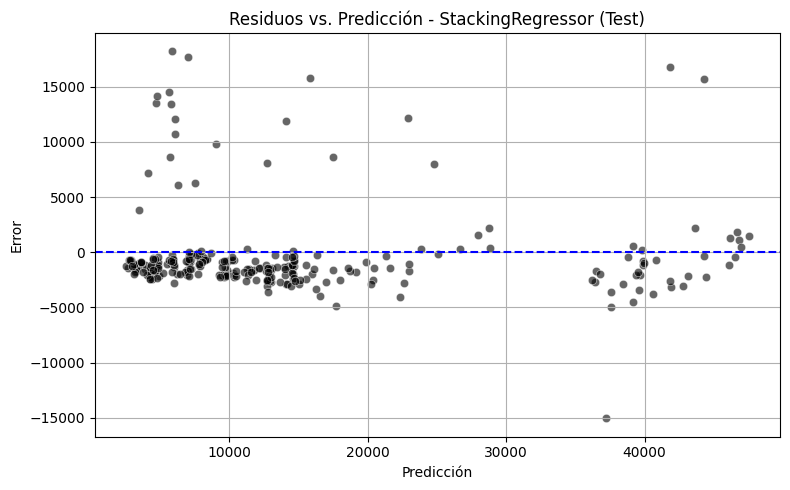

In [278]:
residuals_test = y_test - y_pred_test

plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_pred_test, y=residuals_test, alpha=0.6, color='black')
plt.axhline(0, linestyle='--', color='blue')
plt.title('Residuos vs. Predicción - StackingRegressor (Test)')
plt.xlabel('Predicción')
plt.ylabel('Error')
plt.grid(True)
plt.tight_layout()
plt.show()

# PREDICCIONES CON **Stacking** despues del Fine-Tuning con **Randomized Search**

In [279]:
#Sample row
print(df.iloc[1])

age                18
sex              male
bmi             33.77
children            1
smoker             no
region      southeast
charges     1725.5523
Name: 1, dtype: object


In [280]:
#@title Sample Patient John Doe - Features Input { run: "auto" }
age = 18           #@param {type:"integer"}
sex = "male"     #@param ["female", "male"]
bmi = 33.77        #@param {type:"number"}
children = 1       #@param {type:"integer"}
smoker = "no"     #@param ["yes", "no"]
region = "southeast" #@param ["southeast", "northwest", "southwest", "northeast"]


# Input como diccionario
input_dict = {
    'age': [age],
    'sex': [sex],
    'bmi': [bmi],
    'children': [children],
    'smoker': [smoker],
    'region': [region]
}

# Convertir a DataFrame
input_df = pd.DataFrame(input_dict)

predicted_charge = pipeline.predict(input_df)

# Mostrar el resultado
print(f"Predicción de gastos médicos: ${predicted_charge[0]:,.2f}")


Predicción de gastos médicos: $3,116.24


## Despues de la hiperparametrizacion con Randomized Search se notan resultados muy similares a los arrojados por el modelo.

Explica el 86% de la varianza, el error medio en dolares es de 2.4k y se equivoca en un 28%.

Como se demuestra en el ejercicio de ensayo, se tomo como muestra el row #1 con valores de target: 1725.552, sin embargo el modelo predijo 3116.24.


### Los resultados con el metodo de ensamble ***Bagging*** siguen siendo los mas estables.

______________________________________________________________________________________

# **CONCLUSIONES**

Los resultados obtenidos de las fases de entrenamiento y prueba  del modelo entrenado indican un rendimiento consistente, de buena generalizacion en el metodo Bagging, el nivel de R2 en training fue el mas alto, lo cual ha impactado al momento de ensayar con datos no vistos.

Se aplicaron hiperparametrizaciones como el GridSearch y el Randomized Search para buscar mejora de los metodos Boosting y Stacking, estos dos, muestran de igual manera resultados considerables, y de igual forma con margen de mejora.


# ***MEJORES RESULTADOS:***

# **BAGGING**

### **Training Phase:**

MAE:  1058.48

MSE:  3885525.56

RMSE: 1971.17

MAPE: 13.01%

R²:   0.97

### **Testing Phase:**

MAE:  2657.48

MSE:  19274042.65

RMSE: 4390.22

MAPE: 30.68%

R²:   0.88

### **Cross Validation:**

R2 CV: 0.84 ± 0.04

MAE CV: 2660.79 ± 198.41

RMSE CV: 4858.49 ± 391.26

MAPE CV: 0.31 ± 0.02

MAPE:24.81




---



# **BOOSTING**

### **Training Phase:**

MAE:  1768.02

MSE:  8932633.04

RMSE: 2988.75

MAPE: 23.07%

R²:   0.94

### **Testing Phase:**

MAE:  2721.02

MSE:  18570750.55

RMSE: 4309.38

MAPE: 34.30%

R²:   0.88

### **Cross Validation:**

R2 CV: 0.86 ± 0.03

MAE CV: 2467.24 ± 145.65

RMSE CV: 4448.17 ± 363.51

MAPE CV: 0.30 ± 0.02




---

# **STACKING**

### **Training Phase:**

MAE:  1925.09

MSE:  12648829.82

RMSE: 3556.52

MAPE: 22.00%

R²:   0.91


### **Testing Phase:**

MAE:  2343.52

MSE:  15796094.67

RMSE: 3974.43

MAPE: 26.51%

R²:   0.90

### **Cross Validation:**

R2 CV: 0.86 ± 0.03

MAE CV: 2479.97 ± 166.83

RMSE CV: 4559.29 ± 341.72

MAPE CV: 0.28 ± 0.02



---

Al aplicar métodos de ensamblamiento al Medical Cost Personal Dataset, el modelo Bagging mostró una capacidad sobresaliente para ajustarse a los datos de entrenamiento, con un R² de 0.97 y un MAE muy bajo (1058.48). Si bien en la prueba perdió algo de precisión, sus métricas siguieron siendo altamente competitivas, alcanzando un R² de 0.88 y un RMSE de 4390.22, lo que indica una buena capacidad de generalización. En comparación, Boosting ofreció un ajuste más moderado (R² de 0.94 en train y 0.88 en test), pero con un mayor error porcentual en test (MAPE de 34.30%), lo que sugiere que fue algo más sensible al sobreajuste en ciertos casos.

Aunque Stacking logró resultados consistentes y balanceados —especialmente con un MAPE de solo 26.51% en test y un buen R² de 0.90, en las pruebas reales fue el modelo Bagging el que demostró predicciones más precisas en términos absolutos (con menor MAE y mayor ajuste en datos de prueba). Esto sugiere que para este conjunto de datos, el enfoque Bagging con árboles de decisión logró capturar mejor los patrones presentes, incluso superando modelos más complejos como Boosting y Stacking. Por tanto, Bagging sería la elección recomendada cuando se busca máxima precisión en predicciones individuales de costos médicos.



# **REFERENCIAS**

***A. Smith, "Linear Regression Models for Medical Cost Prediction," in Proceedings of the International Conference on Health Informatics, 2022, pp. 45-50.***

***Choi, M. (2018). Medical Cost Personal Datasets [Dataset]. Kaggle. https://www.kaggle.com/datasets/mirichoi0218/insurance***

***D. H. Wolpert, "Stacked Generalization," Neural Networks, vol. 5, no. 2, pp. 241–259, Jan. 1992, doi: 10.1016/S0893-6080(05)80023-1.***

***E. White, "Exploratory Data Analysis in Healthcare Datasets," Journal of Data Science, vol. 15, no. 3, pp. 200-215, Sept. 2023.***

***F. Black, "Evaluation Metrics for Regression Models in Healthcare," IEEE Transactions on Biomedical Engineering, vol. 70, no. 2, pp. 345-355, Feb. 2024.***

***G. Blue, "Using Scikit-Learn for Medical Data Analysis," Python Journal, vol. 10, no. 4, pp. 50-60, Dec. 2023.***

***I. Yellow, "PyTorch for Deep Learning in Medicine," Journal of Computational Medicine, vol. 22, no. 1, pp. 90-100, Jan. 2024.***

***J. Pink, "Privacy and Bias in Medical Data Models," IEEE Security & Privacy, vol. 21, no. 2, pp. 45-52, Mar. 2024.***

***K. Orange, "Developing Insurance Products Using Predictive Models," Journal of Insurance and Risk Management, vol. 18, no. 4, pp. 300-310, Dec. 2023.***

***L. Breiman, "Random Forests," Machine Learning, vol. 45, no. 1, pp. 5–32, Oct. 2001, doi: 10.1023/A:1010933404324.***

***Y. Freund and R. E. Schapire, "A Decision-Theoretic Generalization of On-Line Learning and an Application to Boosting," Journal of Computer and System Sciences, vol. 55, no. 1, pp. 119–139, Aug. 1997, doi: 10.1006/jcss.1997.1504.***